# EXTRAÇÃO DE MANGA PELO SITE MANGALIVRE

## Setup

### Dependencias do SO
É necessario fazer a instalação das seguintes dependencias do SO Linux (Ubuntu):
1) Instale o Google Chrome
```sh
sudo apt-get install -y curl unzip xvfb libxi6 libgconf-2-4 && \
    wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb && \
    sudo apt install ./google-chrome-stable_current_amd64.deb -y && \
    google-chrome --version
```
2) Instale o Chromedriver baseado na versão no Google-Chrome. Nesse momento a versão é a `108.0.5359.71`:
```sh
wget https://chromedriver.storage.googleapis.com/108.0.5359.71/chromedriver_linux64.zip && \
    unzip chromedriver_linux64.zip && \
    sudo mv chromedriver /usr/bin/chromedriver && \
    sudo chown root:root /usr/bin/chromedriver && \
    sudo chmod +x /usr/bin/chromedriver
```
> - [https://chromedriver.chromium.org/](https://chromedriver.chromium.org/)

### Dependencias do Python
```sh
poetry add pydash selenium-wire
```

## WebDriver + MangaLivre

In [20]:
from __future__ import annotations

import traceback
import base64
from uuid import uuid4
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.webdriver import WebDriver
from seleniumwire.webdriver import Chrome
from seleniumwire.request import Request
from selenium.webdriver.common.by import By
from pathlib import Path
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time


WINDOW_SIZE = "1920x1080"  # "1366x768"
FILE_PATH = Path("./files")


def salvar_tela(webdriver: WebDriver):
    file_path = str(FILE_PATH.resolve().joinpath(f"prints/{uuid4()!s}.png"))
    webdriver.save_screenshot(file_path)
    print(f">> print {webdriver.current_url=} / {file_path=}")


class ChromeWebDriver:
    def __init__(self, implicitly_wait: int = 0, headers: dict[str, str] = None):
        self._webdriver: WebDriver = None
        self._implicitly_wait = implicitly_wait
        self._headers = {}
        if headers and isinstance(headers, dict):
            self._headers.update(headers)
        self._options = Options()
        prefs = {
            "download.default_directory": str(FILE_PATH.resolve()),
            "download.prompt_for_download": False,
            "directory_upgrade": True,
            "safebrowsing.enabled": True,
        }
        self._options.add_experimental_option("prefs", prefs)
        self._options.add_experimental_option(
            "excludeSwitches", ["load-extension", "enable-automation"]
        )
        self._options.add_argument("--disable-extensions")
        self._options.add_argument("--headless")
        self._options.add_argument("--no-sandbox")
        # self._options.add_argument("--disable-dev-shm-usage")
        self._options.add_argument("window-size=" + ",".join(WINDOW_SIZE.split("x")))  # self._options.add_argument("window-size=1366,768")

    def __enter__(self) -> WebDriver:
        return self.webdriver

    def __exit__(self, exc_type, exc_value, exc_traceback) -> None:
        if exc_type:
            print("".join(traceback.format_exception(exc_type, exc_value, exc_traceback)))
        self.quit()
        self.__del__()

    def __del__(self) -> None:
        del self

    def _interceptor(self, request: Request):
        for hk, hv in self._headers.items():
            if request.headers.get(hk):
                del request.headers[hk]
            request.headers[hk] = hv

    @property
    def webdriver(self) -> WebDriver:
        if not self._webdriver:
            self._webdriver = Chrome("chromedriver", options=self._options)
            self._webdriver.request_interceptor = self._interceptor
            if self._implicitly_wait:
                self._webdriver.implicitly_wait(self._implicitly_wait)
        return self._webdriver

    def quit(self):
        if self._webdriver:
            self._webdriver.quit()


class MangaPagina:
    def __init__(self, manga_capitulo_id: int, pagina: int, imagens: list[str]):
        self.pagina = pagina
        self.imagens: list[str] = imagens
        self.manga_capitulo_id = manga_capitulo_id
        self.id = id(self)

    def __str__(self) -> str:
        return f"<MangaPagina id='{self.id}'>"

    def __repr__(self) -> str:
        return str(self)


class MangaCapitulo:
    def __init__(self, nome: str, capitulo: str, qtde_paginas: int = 0):
        self.nome = nome
        self.capitulo = capitulo
        self.qtde_paginas = qtde_paginas
        self.id = id(self)
        self.paginas: list[MangaPagina] = []

    def __str__(self) -> str:
        return f"<MangaCapitulo id='{self.id}'>"
        
    def __repr__(self) -> str:
        return str(self)

    def adicionar_pagina(self, pagina: MangaPagina):
        self.paginas.append(pagina)
        
    def pagina_em_html(self, numero_pagina: int = 1) -> str:
        html = "<div>"
        for n, imagem in enumerate(self.paginas[numero_pagina-1].imagens):
            if n > 0:
                html += "<br>"
            html += f'<img src="data:image/png;base64,{imagem}" />'
        html += "</div>"
        return html


class MangaLivre:
    DELAY = 10
    
    def __init__(self):
        self._chrome_webdriver = ChromeWebDriver(implicitly_wait=self.DELAY)
        self._delay = self.DELAY
        self.test = []

    def _obter_scans(self, url: str) -> dict[int, str]:
        with self._chrome_webdriver as webdriver:
            pagina = {}
            xpath_image = '//div[@class="manga-image"]/picture/img'
            num_pag = 0
            total_pag = 999
            while num_pag < total_pag:
                url_paginada = f"{url}#/!page{num_pag!s}"
                webdriver.get(url_paginada)
                self._esperar_renderizacao(webdriver)
                pagina[num_pag+1] = []
                elem = webdriver.find_element(By.XPATH, xpath_image)
                salvar_tela(webdriver)
                pagina[num_pag+1].append(elem.screenshot_as_base64)
                if not num_pag:
                    total_pag = int(webdriver.find_element(By.XPATH, '//em[@reader-total-pages=""]').text)
                num_pag += 1
        return pagina

    def _esperar_renderizacao(self, webdriver: WebDriver):
        delay_parcial = self.DELAY / 2
        while webdriver.execute_script("return document.readyState") != "complete":
            time.sleep(delay_parcial)

    def extrair_manga(self, nome: str, url: str) -> MangaCapitulo:
        capitulo = url.split("/").pop()
        pag_scans = self._obter_scans(url)
        manga = MangaCapitulo(nome=nome, capitulo=capitulo, qtde_paginas=len(list(pag_scans.keys())))
        for pag, imgs in pag_scans.items():
            pagina = MangaPagina(manga_capitulo_id=manga.id, pagina=int(pag), imagens=imgs)
            manga.adicionar_pagina(pagina)
        return manga


## Extração

In [19]:
mangalivre = MangaLivre()
manga = mangalivre.extrair_manga(
    nome="One Punch Man",
    url="https://mangalivre.net/ler/one-punch-man/online/428424/211",
)
manga

Traceback (most recent call last):
  File "/tmp/ipykernel_10648/1008628575.py", line 141, in _obter_scans
    self._esperar_renderizacao()
TypeError: MangaLivre._esperar_renderizacao() missing 1 required positional argument: 'webdriver'



TypeError: MangaLivre._esperar_renderizacao() missing 1 required positional argument: 'webdriver'


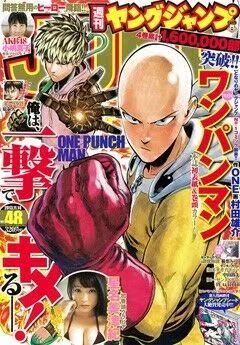

In [6]:
from IPython import display

display.HTML(manga.pagina_em_html(5))

## Desenvolvimento

In [ ]:
chrome_webdriver = ChromeWebDriver()
webdriver = chrome_webdriver.webdriver
webdriver

In [ ]:
webdriver.quit()